# Block Size is 11
<u>*Experiment Configuration*</u>
|Configuration|Value|
|---|:--:|
|Blocks|11|
|Parent Selection|top_two|
|Mutation|point|
|Merge|center|
|Primitives|['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity']|
|||

<u>*Kaggle Run*</u>: https://www.kaggle.com/code/naresh/amoebanet?scriptVersionId=113907086

<u>*Best Architectures*</u>
|Block|Normal|Reduction|
|:-:|-|-|
|1.|`[0, 1, 4, 2, 1]`|`[1, 1, 1, 0, 1]`|
|2.|`[1, 1, 4, 1, 0]`|`[1, 1, 0, 1, 1]`|
|3.|`[1, 1, 1, 1, 1]`|`[0, 0, 4, 5, 1]`|
|4.|`[0, 1, 5, 4, 0]`|`[0, 0, 0, 5, 0]`|
|5.|`[0, 1, 2, 1, 0]`|`[1, 0, 2, 3, 1]`|
|6.|`[3, 6, 2, 4, 0]`|`[5, 4, 1, 3, 1]`|
|7.|`[5, 6, 4, 3, 1]`|`[3, 2, 5, 4, 1]`|
|8.|`[5, 6, 2, 2, 0]`|`[3, 5, 4, 3, 0]`|
|9.|`[6, 5, 2, 0, 0]`|`[3, 5, 4, 5, 0]`|
|10.|`[2, 5, 4, 2, 0]`|`[6, 5, 1, 3, 1]`|
|11.|`[6, 6, 3, 0, 1]`|`[3, 2, 4, 1, 1]`|
||||

<!--
data = [
  [
      [0, 1, 4, 2, 1],
      [1, 1, 4, 1, 0],
      [1, 1, 1, 1, 1],
      [0, 1, 5, 4, 0],
      [0, 1, 2, 1, 0],
      [3, 6, 2, 4, 0],
      [5, 6, 4, 3, 1],
      [5, 6, 2, 2, 0],
      [6, 5, 2, 0, 0],
      [2, 5, 4, 2, 0],
      [6, 6, 3, 0, 1]
    ],

    [
      [1, 1, 1, 0, 1],
      [1, 1, 0, 1, 1],
      [0, 0, 4, 5, 1],
      [0, 0, 0, 5, 0],
      [1, 0, 2, 3, 1],
      [5, 4, 1, 3, 1],
      [3, 2, 5, 4, 1],
      [3, 5, 4, 3, 0],
      [3, 5, 4, 5, 0],
      [6, 5, 1, 3, 1],
      [3, 2, 4, 1, 1]
    ]
  ]

normal, reduction = data
for b_id in range(len(normal)):
  fmt = '|{}.|`[{}, {}, {}, {}, {}]`|`[{}, {}, {}, {}, {}]`|'
  print(fmt.format(b_id+1, *normal[b_id], *reduction[b_id]))
-->

<br>
<section>
  <h2>Best Cell</h2>
  <img src='amoeba.v5.best.cells.png' width="70%">
</section>

## Installation

In [1]:
%%capture
# !pip install mplcursors
!pip install -q git+https://github.com/EfficientDL/codelab_utils.git

## Import Modules used in this Notebook

In [2]:
import random
import seaborn
import numpy.typing
import traceback

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import codelab_utils.mpl_styles as mpl_styles
import networkx as nx

from tensorflow.keras import layers, losses, models, optimizers
from matplotlib import pyplot as plt
from matplotlib import ticker
from collections import deque
from random import sample, shuffle, randrange
from math import floor
from functools import reduce
from typing import List, Tuple

SEED = 111

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

## Dataset Setup

In [3]:
%%capture
# DATASET = 'mnist'
DATASET = 'cifar10'

if DATASET == 'mnist':
    DATASET_PARAMS = dict(
        input_shape=(28, 28, 3),
        n_classes=10,
        baseline_accuracy=.3,
        train_batch_size=128
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

    gray_to_rgb = lambda image, label: (tf.repeat(image, 3, axis=-1), label)
    train_ds = train_ds.map(gray_to_rgb)
    val_ds = val_ds.map(gray_to_rgb)
elif DATASET == 'cifar10':
    DATASET_PARAMS = dict(
        input_shape=(32, 32, 3),
        n_classes=10,
        baseline_accuracy=.1,
        train_batch_size=128
    )

    train_ds, val_ds = tfds.load(
        DATASET,
        split=['train[:80%]', 'train[20%:]'],
        as_supervised=True
    )

# Hack to run on Kaggle
TDS = train_ds.shuffle(
    500,
    reshuffle_each_iteration=True
).batch(DATASET_PARAMS['train_batch_size'])
VDS = val_ds.batch(256)

for item in TDS: pass
for item in VDS: pass

2022-12-15 13:44:59.763646: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2022-12-15 13:45:07.204876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:45:07.299733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 13:45:07.300576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

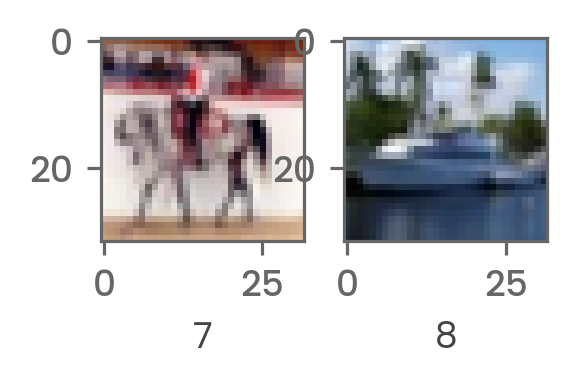

In [4]:
def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, item in enumerate(display_list):
        image, label = item
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))
        axis.set_xlabel(label)

items = []
for item in train_ds.take(2).as_numpy_iterator():
    items.append(item)

display(items, size=(2,2))

## Configuration

In [5]:
CHILD_PARAMS = dict(
    epochs=7,
#     epochs=1,
    batch_size=DATASET_PARAMS['train_batch_size'],
    learning_rate=0.001,
    train_ds=train_ds,
    val_ds=val_ds,
    max_branch_length=2,
    blocks=11,
    cells=2,
    layers=[(0, 8), (1, 16), (0, 32), (1, 64), (0, 128)],
#     layers=[(0, 4), (1, 64), (0, 128), (1, 512), (0, 1024)],
#     layers=[(0, 4), (1, 64), (0, 128), (1, 256), (0, 512)],
)

CONTROLLER_PARAMS = dict(
    episodes=80,
#     episodes=2,
    population_size=20,
    sample_size=12,
    max_mutations=3,
#     mutation_strategy='mixed',
    mutation_strategy='point',
    merge_strategy='center_merge',
    parent_selection_strategy='top_two',
)


## Support Classes

In [6]:
class NumpyOps(object):
    def with_indices(self, a):
        rows, cols = a.shape
        row_indices = np.array(list(range(rows))).reshape((rows, 1))
        col_indices = np.array([0] + list(range(cols))).reshape((1, cols+1))

        result = np.concatenate([row_indices, a], axis=1)
        result = np.concatenate([col_indices, result], axis=0)
        return result

class RandomOps(object):
    def choice(self, s):
        return random.choice(s)
    
    def choice_with_index(self, s):
        s_id = random.choice(range(len(s)))
        element = s[s_id]
        return s_id, element

random_ops = RandomOps()
numpy_ops = NumpyOps()

## Search Space

In [7]:
class StateSearchSpace(object):
    def __init__(self, name='state', choices=[], size=2, labels=[]) -> None:
        self.name = name
        self.choices = choices or list(range(size))
        self.labels = labels or self.choices
    
    def __str__(self) -> str:
        return '{}: {}'.format(
            self.name,
            self.labels
        )
    
    def __len__(self) -> int:
        return len(self.choices)
    
    def __getitem__(self, address):
        return self.choices[address]
    
    def random(self):
        return random_ops.choice(self.choices)
    
    def random_element(self, level):
        state = random_ops.choice(self.choices)
        return state
    
    def decode(self, state):
        index = self.choices.index(state)
        return self.labels[index]
    
class BlockSearchSpace(object):
    def __init__(self) -> None:
        self.elements = []
    
    def add_state(self, kwargs):
        state = StateSearchSpace(**kwargs)
        self.elements.append(state)

        return state
    
    def __str__(self) -> str:
        desc = 'States\n======\n'
        desc += '\n'.join(map(str, self.elements))
        return desc
    
    def __len__(self) -> int:
        return len(self.elements)
    
    def __getitem__(self, address):
        return self.elements[address]
    
    def random(self) -> np.typing.NDArray[int]:
        return np.array(list(
            map(lambda s: s.random(), self.elements)
        ))
    
    def random_element(self, level):
        s_id, elem = random_ops.choice_with_index(self.elements)

        if level == 0:
            address, elem = (s_id,), elem
        else:
            elem = elem.random_element(level-1)
            address = (s_id,)

        return address, elem
    
    def decode(self, block):
        return np.array(list(map(
            lambda p: p[1].decode(block[p[0]]),
            enumerate(self.elements)
        )))
        

class CellSearchSpace(object):
    def __init__(self, block_search_space, blocks=1) -> None:
        self.block_search_space = block_search_space
        self.blocks = blocks
        self.cell_search_space = np.array(list(
            map(
                lambda _: list(map(lambda s: s.name, block_search_space.elements)),
                range(blocks)
            )
        ))
    
    def __str__(self) -> str:
        return str(self.cell_search_space)
    
    def __len__(self) -> int:
        return self.cell_search_space.size
    
    def __getitem__(self, address):
        return self.cell_search_space[address]

    def random(self):
        return np.array(list(
            map(
                lambda _: self.block_search_space.random(),
                range(self.blocks)
            )
        ))

class TwoLevelCellSearchSpace(object):
    def __init__(self, child_params) -> None:
        self.child_params = child_params
        self.input_labels = ['input 0', 'input 1']
        self.block_labels = list(map(
            lambda b_id: 'block {}'.format(b_id),
            range(self.child_params['blocks'])
        ))

        # State Descriptions
        self.primitives = dict(
            name='primitives',
            size=6,
            labels=['sep_3x3', 'sep_5x5', 'sep_7x7', 'avg_3x3', 'max_3x3', 'identity']
        )
        self.combinations = dict(
            name='combinations',
            size=2,
            labels=['add', 'concat']
        )

        # Block Search Spaces
        self.blocks = self.create_search_space()
        self.cell_search_space_names = np.array(list(map(
            lambda b: list(map(lambda s: s.name, b.elements)),
            self.blocks
        )))
    
    def create_search_space(self):
        return self.create_first_level() + self.create_second_level()
    
    def create_first_level(self):
        block_count = self.child_params['blocks']//2
        inputs = dict(name='inputs', size=2, labels=self.input_labels)

        def create_block(_):
            block = BlockSearchSpace()
            states = list(map(
                block.add_state,
                [
                    inputs,
                    inputs,
                    self.primitives,
                    self.primitives,
                    self.combinations
                ]
            ))
            return block

        return list(map(
            create_block,
            range(block_count)
        ))
    
    def create_second_level(self):
        level_1_block_count = self.child_params['blocks']//2
        level_2_block_count = self.child_params['blocks'] - level_1_block_count
    
        # Second level input labels
        left_input_labels = self.input_labels + self.block_labels[:level_1_block_count]
        right_input_labels = self.block_labels[:level_1_block_count]

        # Second level input states
        left_inputs = dict(
            name='mixed',
            size=len(left_input_labels),
            labels=left_input_labels
        )
        right_inputs = dict(
            name='blocks',
            # size=len(right_input_labels),
            choices=list(range(len(self.input_labels), len(left_input_labels))),
            labels=right_input_labels
        )

        def create_block(_):
            block = BlockSearchSpace()
            states = list(map(
                block.add_state,
                [
                    left_inputs,
                    right_inputs,
                    self.primitives,
                    self.primitives,
                    self.combinations
                ]
            ))
            return block

        return list(map(
            create_block,
            range(level_2_block_count)
        ))
    
    def __str__(self) -> str:
        return np.array2string(self.cell_search_space_names)
    
    def __len__(self) -> int:
        return len(self.blocks)
    
    def size(self) -> int:
        return self.cell_search_space_names.size
    
    def describe(self) -> np.typing.NDArray[str]:
        return self.cell_search_space_names
    
    @property
    def shape(self) -> Tuple[int]:
        return self.cell_search_space_names.shape
    
    def __getitem__(self, address):
        return self.blocks[address]
    
    def random(self):
        return np.array(list(
            map(
                lambda b: b.random(),
                self.blocks
            )
        ))
    
    def random_element(self, level, desc=False):
        b_id, block = random_ops.choice_with_index(self.blocks)

        if level == 0:
            address, elem = (b_id,), block
        else:
            interm_address, elem = block.random_element(level-1)
            address = (b_id,) + interm_address

        result = (address, elem)

        if desc:
            status = np.empty_like(self.cell_search_space_names)
            status[address] = elem if type(elem) is int else 'X'
            result += (status,)

        return result
    
    def decode(self, config):
        return np.array(list(map(
            lambda p: p[1].decode(config[p[0]]),
            enumerate(self.blocks)
        )))


# state = state_space.random()
# state, state_space.decode(state)

# block_space = BlockSearchSpace()
# block_space.add_state(dict(labels=['input 0', 'input 1']))
# block_space.add_state(dict(size=3, labels=['block 0', 'block 1', 'block 2']))
# block_config = block_space.random()
# block_config, block_space.decode(block_config)

search_space = TwoLevelCellSearchSpace(CHILD_PARAMS)
# cell_config = search_space.random()
# print(cell_config)
# search_space.decode(cell_config)

# print(numpy_ops.with_indices(cell_config))
# numpy_ops.with_indices(cell_config)

## Evolution Strategies

In [8]:
class ParentSelectionStrategies(object):
    def __init__(self) -> None:
        self.elementary_strategies = [
            'best',
            'best_and_random',
            'top_two',
        ]
        self.strategies = {
            'best': self.best,
            'best_and_random': self.best_and_random,
            'top_two': self.top_two,
        }
    
    def best_and_random(self, num_candidates):
        best_parent = num_candidates - 1
        random_parent = random.randrange(num_candidates-1)

        return [best_parent, random_parent]
    
    def top_two(self, num_candidates):
        return [num_candidates-1, num_candidates-2]
    
    def best(self, num_candidates):
        best_parent = num_candidates - 1
        return [best_parent, best_parent]
    
    def get(self, name='best_and_random'):
        return self.strategies[name]

class MutationStrategies(object):
    def __init__(self, search_space) -> None:
        # self.child_params = child_params
        self.search_space = search_space
        self.elementary_strategies = ['point', 'block_swap']
        self.strategies = {
            'point': self.point,
            'block_swap': self.block_swap,
            'mixed': self.mixed,
            'gene_shuffle': self.gene_shuffle,
        }
    
    def point(self, config):
        address, value, desc = self.search_space.random_element(2, desc=True)

        old_config = config.copy()
        config[address] = value

        print('Point Mutation\n===============\n', address, value)
        print(desc)
        print(config == old_config)

        return config
    
    def block_swap(self, config):
        coordinates = list(map(
            randrange, [len(self.search_space)]*2
            # randrange, [self.child_params['blocks']]*2
        ))
        old_config = config.copy()
        config[coordinates] = config[list(reversed(coordinates))]
        print('Block Swap\n===============\n', coordinates)
        print(config == old_config)

        return config
    
    def mixed(self, config):
        strategy_id = randrange(len(self.elementary_strategies))
        
        return self.strategies[self.elementary_strategies[strategy_id]](config)
    
    def gene_shuffle(self, config):
        block_indices = list(range(config.shape[0]))
        random.shuffle(block_indices)

        # Select Genes
        selected = config[block_indices[:len(self.search_space)]]
        print('Gene Shuffle\n============\n', block_indices[:len(self.search_space)])
        return selected

    def get(self, name='point'):
        return self.strategies[name]

class MergeStrategies(object):
    def __init__(self, search_space, mix_strategy) -> None:
        self.elementary_strategies = [
            'pick_first',
            'mix_two',
            'center_merge'
        ]
        self.strategies = {
            'pick_first': self.pick_first,
            'mix_two': self.mix_two,
            'center_merge': self.center_merge
        }
        self.mix_strategy = mix_strategy
        self.search_space = search_space
    
    def pick_first(self, *parents):
        return parents[0]

    def mix_two(self, *parents):
        first, second = parents
        return np.array(list(
            map(
                lambda c: self.mix_strategy(np.concatenate(c)),
                zip(first, second)
            )
        ))
    
    def center_merge(self, *parents):
        first, second = parents
        left_merge_point = len(self.search_space)//2
        right_merge_point = (len(self.search_space)+1)//2
        merge_point = random.choice([left_merge_point, right_merge_point])

        return np.array(list(
            map(
                lambda c: np.concatenate([c[0][:merge_point], c[1][merge_point:]]),
                zip(first, second)
            )
        ))

    def get(self, name='pick_first'):
        return self.strategies[name]

mutation_strategies = MutationStrategies(search_space)
merge_strategies = MergeStrategies(
    search_space,
    mutation_strategies.get('gene_shuffle')
)

# cell_config = search_space.random()
# mutation_strategies.point(cell_config)
# search_space.random_element(1, desc=True)
# mutation_strategies.point(cell_config)
# mutation_strategies.block_swap(cell_config)
# mutation_strategies.mixed(cell_config)
# mutation_strategies.gene_shuffle(cell_config)
# config_1 = random_child_config(CHILD_PARAMS, search_space)
# config_2 = random_child_config(CHILD_PARAMS, search_space)
# merged = merge_strategies.center_merge(config_1, config_2)
# merged = merge_strategies.pick_first(config_1, config_2)
# merged = merge_strategies.mix_two(config_1, config_2)
# config_1 == merged, config_2 == merged

## Cell Block

* Support to reduce channels
* Debug

In [9]:
class CellBlock():
    """
    It composes a cell based on the input configuration.
    Arguments:
        channels: Number of output channels
    """
    def __init__(self, channels=64):
        self.channels = channels
    
    def apply_op(self, op_id, inp):
        """
        It applies a primitive operation to the input.
        """
        kwargs = dict(strides=(1, 1), padding='same')
        if op_id == 0:
            output = layers.DepthwiseConv2D(3, **kwargs)(inp)
        elif op_id == 1:
            output = layers.DepthwiseConv2D(5, **kwargs)(inp)
        elif op_id == 2:
            output = layers.DepthwiseConv2D(7, **kwargs)(inp)
        elif op_id == 3:
            output = layers.AveragePooling2D(3, **kwargs)(inp)
        elif op_id == 4:
            output = layers.MaxPool2D(3, **kwargs)(inp)
        elif op_id == 5:
            output = inp
        
        return output

    def combination(self, op_id, inp_1, inp_2):
        """
        It applies a combination operation to the inputs.
        """
        if op_id == 0:
            output = inp_1 + inp_2
        elif op_id == 1:
            x = tf.concat([inp_1, inp_2], -1)
            output = self.repair_channels(x)
        
        return output

    def compose_block(self, block_config, inputs):
        input_0, input_1 = list(map(inputs.__getitem__, block_config[:2]))
        op1, op2, combine_op = block_config[2:]
        # print(block_config)

        output = self.combination(
            combine_op,
            self.apply_op(op1, input_0),
            self.apply_op(op2, input_1)
        )

        return output
    
    def repair(self, x, strides=[]):
        """
        Stacks conv layers according to strides over the input 'x'.
        """
        return reduce(
            lambda y,stride: layers.Conv2D(
                self.channels,
                3,
                strides=(stride, stride),
                padding='same'
            )(y),
            strides,
            x
        )
    
    def repair_inputs(self, inputs):
        """
        It transforms the inputs to an identical feature space.
        It is useful when a cell receives inputs with different feature spaces.
        
        We reduce by a factor of 2 in each step. For an incoming input with 4x
        the feature space of the last layer, we stack 2 conv layers
        to achieve the desired reduction.
        """
        input_feature_size = inputs[-1].shape[-2]
        reductions = list(map(
            lambda x: [2]*(x.shape[-2]//input_feature_size-1),
            inputs
        ))
        return list(map(
            lambda p: self.repair_channels(self.repair(p[0], p[1])),
            zip(inputs, reductions)
        ))
    
    def repair_channels(self, x):
        """
        This method sends the input through a convolution layer with
        a fixed channel size to ensure that the inputs to each cell block
        have identical channel dimensions.
        """
        if x.shape[-1] != self.channels:
            x = layers.Conv2D(self.channels, 1, padding='same')(x)

        return x        
    
    def make_cell(self, cell_config, inputs, apply_reduction=False):
        """
        It constructs a cell based on the cell_config and the inputs.
        A cell_config is 2-D numpy array of shape [N,5] which contains
        the 5 state choices for each cell block.
        """
        # Reduce inputs, if requested.
        # BUG BUG
        last_input = inputs[-1]
        inputs.append(self.repair(last_input, [2]) if apply_reduction else last_input)

        inputs = self.repair_inputs(inputs)
        # print(inputs)

        blocks = []
        for b_id, block in enumerate(cell_config):
            block_output = self.compose_block(block, inputs + blocks)
            blocks.append(block_output)
        
        x = tf.concat(blocks, -1)
        x = self.repair_channels(x)
        return x

def create_child(config):
    inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
    x = layers.Rescaling(1./255)(inp)

    branches = deque([x, x], maxlen=CHILD_PARAMS['max_branch_length'])
    for cell_type, channels in CHILD_PARAMS['layers']:
        cnn_cell = CellBlock(channels)
        x = cnn_cell.make_cell(config[cell_type], list(branches), apply_reduction=bool(cell_type))
        
        branches.append(x)
    
    model = tf.keras.Model(inp, x)
    optimizer = optimizers.Adam()

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics='accuracy'
    )

    return model

# config = np.array([search_space.random(), search_space.random()])
# for cc in config: print(search_space.decode(cc))
# m = create_child(config)
# m.summary()
# tf.keras.utils.plot_model(m)

## Child Architecture

In [10]:
TDS = CHILD_PARAMS['train_ds'].shuffle(
    500,
    reshuffle_each_iteration=True
).batch(CHILD_PARAMS['batch_size'])
VDS = CHILD_PARAMS['val_ds'].batch(256)

class Child(object):
    def __init__(self, config, params, train=True):
        self.config = config
        self.params = params

        """
        Layer configuration is a pair: (layer_type, stride)
        A normal layer take a single stride and a reduction layer
        take a double stride.
        """
        # self.layers = [(0, 1), (1, 2), (0, 1), (1, 2), (0, 1)]
        self.model = self.make_child()
        self.accuracy = 0.0
        self.accuracy = self.train() if train else 0
        print('Child: {} \n Accuracy: {:1.4f}'.format(
            self.config,
            self.accuracy
        ))
    
    def make_child(self):
        """
        Arguments:
            config: It is an array of shape [2, 5, 5]
                    Each row represents a cell: [Normal, Reduction]
                    Each cell contains 5 blocks.
                    Each block contains 5 operations.

        Returns:
            model: A CNN model with the layers laid out based on the input config.
        """
        inp = tf.keras.Input(shape=DATASET_PARAMS['input_shape'], dtype=tf.uint8)
        x = layers.Rescaling(1./255)(inp)

        branches = deque([x, x], maxlen=self.params['max_branch_length'])
        
        for cell_type, channels in self.params['layers']:
            cnn_cell = CellBlock(channels)
            x = cnn_cell.make_cell(self.config[cell_type], list(branches), apply_reduction=bool(cell_type))
            
            branches.append(x)

        x = layers.GlobalAveragePooling2D()(x)
        output = layers.Dense(DATASET_PARAMS['n_classes'], activation='softmax')(x)

        model = tf.keras.Model(inp, output)
        optimizer = optimizers.Adam(learning_rate=self.params['learning_rate'])

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics='accuracy'
        )
        # model.summary()

        return model

    def train(self):
        history = self.model.fit(
            TDS,
            validation_data=VDS,
            epochs=self.params['epochs']
        )
        self.accuracy = max(history.history['val_accuracy'])

        return self.accuracy

# config = np.array(list(map(lambda _: search_space.random(), range(2))))
# for cc in config: print(search_space.decode(cc))
# child = Child(config, CHILD_PARAMS, train=False)
# tf.keras.utils.plot_model(child.model, show_shapes=True)
# child.model.summary()

## Architecture Search

In [11]:
class Controller():
    def __init__(self, params, child_params, search_space):
        self.population_size = params['population_size']
        self.population = deque(maxlen=self.population_size)
        self.histories = []
        self.sample_size = params['sample_size']
        self.best_accuracies = []
        self.best_children = []
        self.params = params
        self.child_params = child_params
        self.search_space = search_space
        self.mutation_strategies = MutationStrategies(search_space)
        self.mutation_strategy = self.mutation_strategies.get(
            self.params['mutation_strategy']
        )
        self.merge_strategies = MergeStrategies(
            search_space,
            self.mutation_strategies.get('gene_shuffle')
        )
        self.merge_strategy = self.merge_strategies.get(
            self.params['merge_strategy']
        )
        self.parent_selection_strategies = ParentSelectionStrategies()
        self.parent_selection_strategy = self.parent_selection_strategies.get(
            self.params['parent_selection_strategy']
        )
    
    def random_child_config(self):
        return np.array(list(map(
            lambda _: self.search_space.random(),
            range(self.child_params['cells'])
        )))

    def create_random_child(self):
        config = self.random_child_config()
        child = Child(config, self.child_params)
#         child = Child(config, self.child_params, train=False)
        return child

    def initialize_population(self):
        """
        It creates children as specified through the size parameter.
        Each child is trained and their history is stored.
        It should be called only once.

        Arguments:
            size: The size of the population.
        """
        def work_fn():
            self.population.extend(map(
                lambda _: self.create_random_child(),
                range(self.sample_size)
            ))
            self.histories += self.population
        
        work_fn() if not self.population else None
    
    def mutate(self, config):
        def mutate_cell(cell_config):
            return reduce(
                lambda c,_: self.mutation_strategy(c),
                range(self.params['max_mutations']),
                cell_config
            )

        mutated_config = np.array(list(
            map(mutate_cell, config.copy())
        ))

        return mutated_config
    
    def choose_parents(self):
        p_sample = sample(range(len(self.population)), self.sample_size)
        sample_accuracies = list(map(
            lambda idx: self.population[idx].accuracy,
            p_sample
        ))
        ordered_sample = np.argsort(sample_accuracies)
        parent_ids = self.parent_selection_strategy(len(p_sample))
        sample_ids = list(map(
            lambda p_id: ordered_sample[p_id],
            parent_ids
        ))
        population_ids = list(map(lambda s_id: p_sample[s_id], sample_ids))
        parents = list(map(lambda p_id: self.population[p_id], population_ids))

        return parents
    
    def record_best(self):
        # Record the best accuracies
        population_accuracies = list(map(
            lambda item: item.accuracy,
            self.population
        ))

        self.best_accuracies.append(max(population_accuracies))
        self.best_children.append(np.argmax(population_accuracies))
    
    def update_population(self, child):
        if len(self.population) == self.population_size:
            print('Removal Candidate: {}\n Accuracy: {:1.5f}'.format(
                self.population[0].config,
                self.population[0].accuracy
            ))

        self.population.append(child)
    
    def reproduce(self, *parents):
        first, second = parents
        merged_config = self.merge_strategy(
            first.config,
            second.config
        )
        mutated_config = self.mutate(merged_config)
        child = Child(mutated_config, self.child_params)
#         child = Child(mutated_config, self.child_params, train=False)

        return child
    
    """How to send sorted configs to parent selection strategy?"""
    def run_cycle(self):
        # Pick parents
        first, second = self.choose_parents()
        print('First Parent: {}\n Accuracy: {:1.5f}'.format(
            first.config,
            first.accuracy
        ))
        print('Second Parent: {}\n Accuracy: {:1.5f}'.format(
            second.config,
            second.accuracy
        ))

        # Reproduce
        mutated_child = self.reproduce(first, second)

        # Update population
        self.update_population(mutated_child)

        # Record best children
        self.record_best()

        # Add the mutated child to the histories
        self.histories.append(mutated_child)

controller = Controller(CONTROLLER_PARAMS, CHILD_PARAMS, search_space)
controller.initialize_population()

for episode in range(CONTROLLER_PARAMS['episodes']):
    print('Cycle: ', episode)
    controller.run_cycle()

Epoch 1/7


2022-12-15 13:46:41.286462: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 43s 99ms/step - loss: 1.8706 - accuracy: 0.3287 - val_loss: 1.6428 - val_accuracy: 0.3869
Epoch 2/7
313/313 [==============================] - 30s 95ms/step - loss: 1.5049 - accuracy: 0.4557 - val_loss: 1.3855 - val_accuracy: 0.4965
Epoch 3/7
313/313 [==============================] - 30s 96ms/step - loss: 1.3335 - accuracy: 0.5231 - val_loss: 1.3110 - val_accuracy: 0.5308
Epoch 4/7
313/313 [==============================] - 30s 95ms/step - loss: 1.1900 - accuracy: 0.5821 - val_loss: 1.1403 - val_accuracy: 0.6008
Epoch 5/7
313/313 [==============================] - 30s 95ms/step - loss: 1.0786 - accuracy: 0.6242 - val_loss: 1.0263 - val_accuracy: 0.6433
Epoch 6/7
313/313 [==============================] - 30s 96ms/step - loss: 0.9951 - accuracy: 0.6553 - val_loss: 0.9392 - val_accuracy: 0.6777
Epoch 7/7
313/313 [==============================] - 30s 95ms/step - loss: 0.9164 - accuracy: 0.6839 - val_loss: 0.8807 - val_accuracy: 0.6960
Child: [[

## Training Metrics

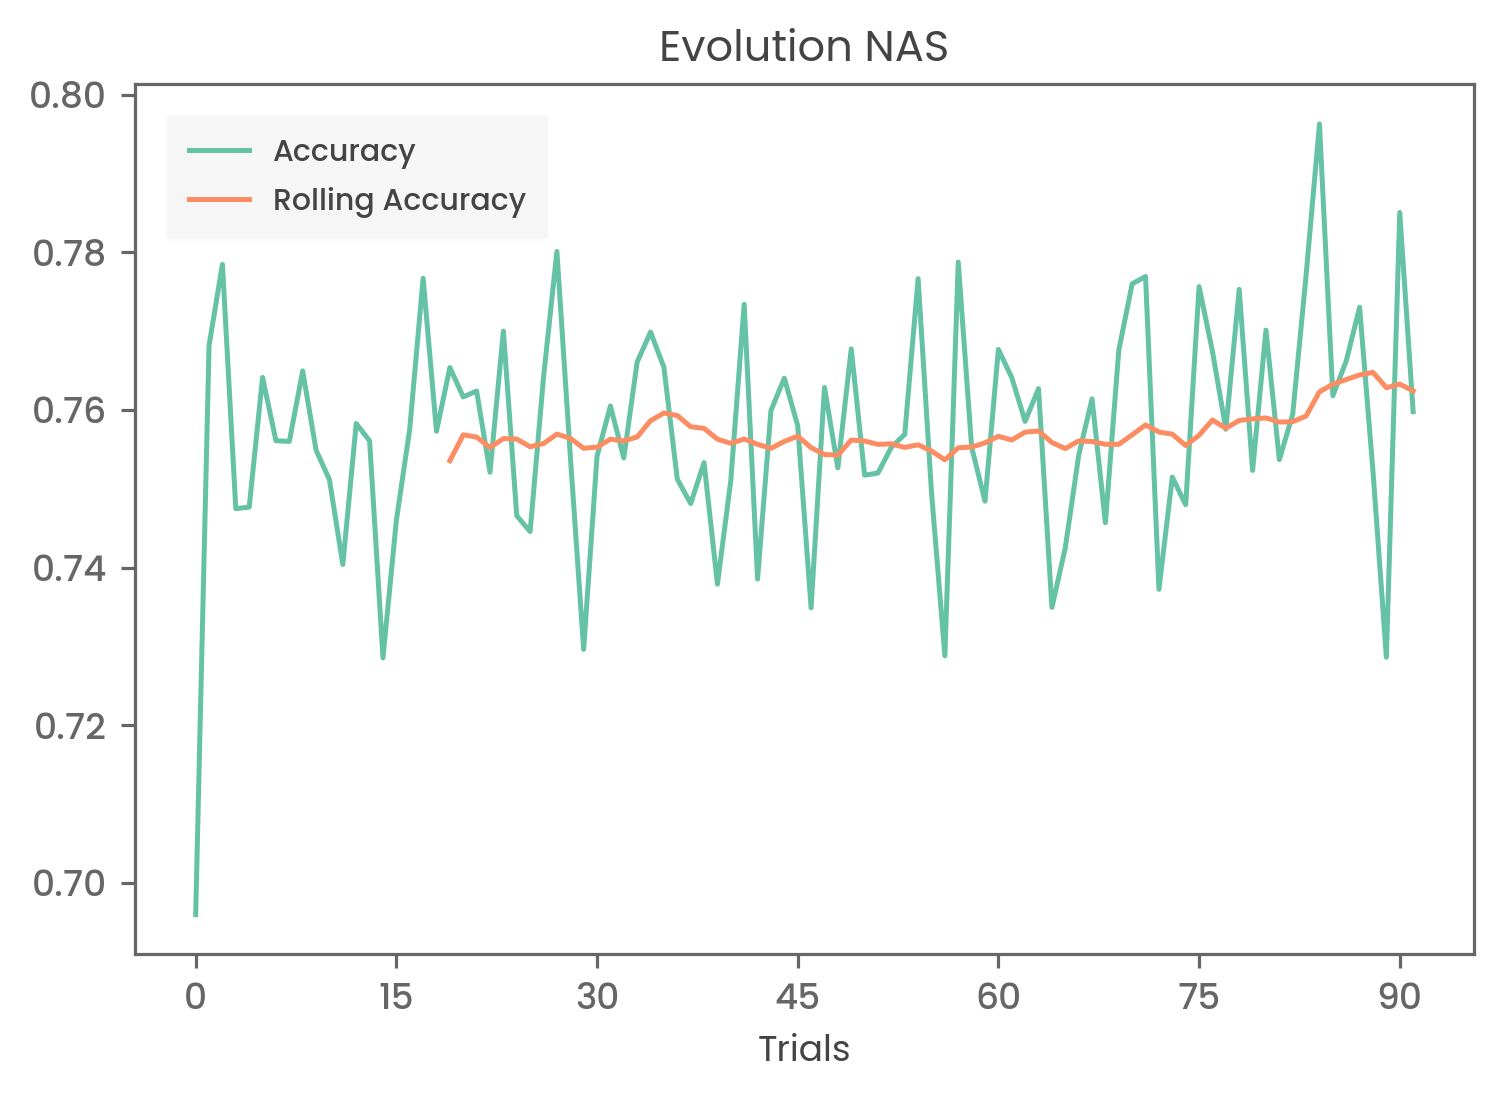

In [12]:
accuracies = list(map(lambda child: child.accuracy, controller.histories))
accuracies_df = pd.DataFrame(accuracies)
rolling_accuracies = accuracies_df.rolling(len(controller.population)).mean()[0].tolist()

plt.plot(accuracies, label='Accuracy')
axes = plt.plot(rolling_accuracies, label='Rolling Accuracy')
plt.xlabel('Trials')
plt.legend()
plt.title('Evolution NAS')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

## Performance Analysis

[0.7785, 0.7785, 0.7785, 0.7785, 0.7785, 0.7785, 0.7785, 0.7785, 0.7785, 0.7785, 0.7767, 0.7767, 0.7767, 0.7767, 0.7767, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7801, 0.7734, 0.7734, 0.7734, 0.7734, 0.7734, 0.7734, 0.7734, 0.7767, 0.7767, 0.7767, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7788, 0.7770, 0.7770, 0.7770, 0.7770, 0.7770, 0.7770, 0.7771, 0.7963, 0.7963, 0.7963, 0.7963, 0.7963, 0.7963, 0.7963, 0.7963]
[2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 14, 13, 12, 11, 10, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13, 12, 11, 10, 9, 8, 7, 19, 18, 17, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13, 12, 11, 10, 9, 8, 19, 19, 18, 17, 16, 15, 14, 13, 12]


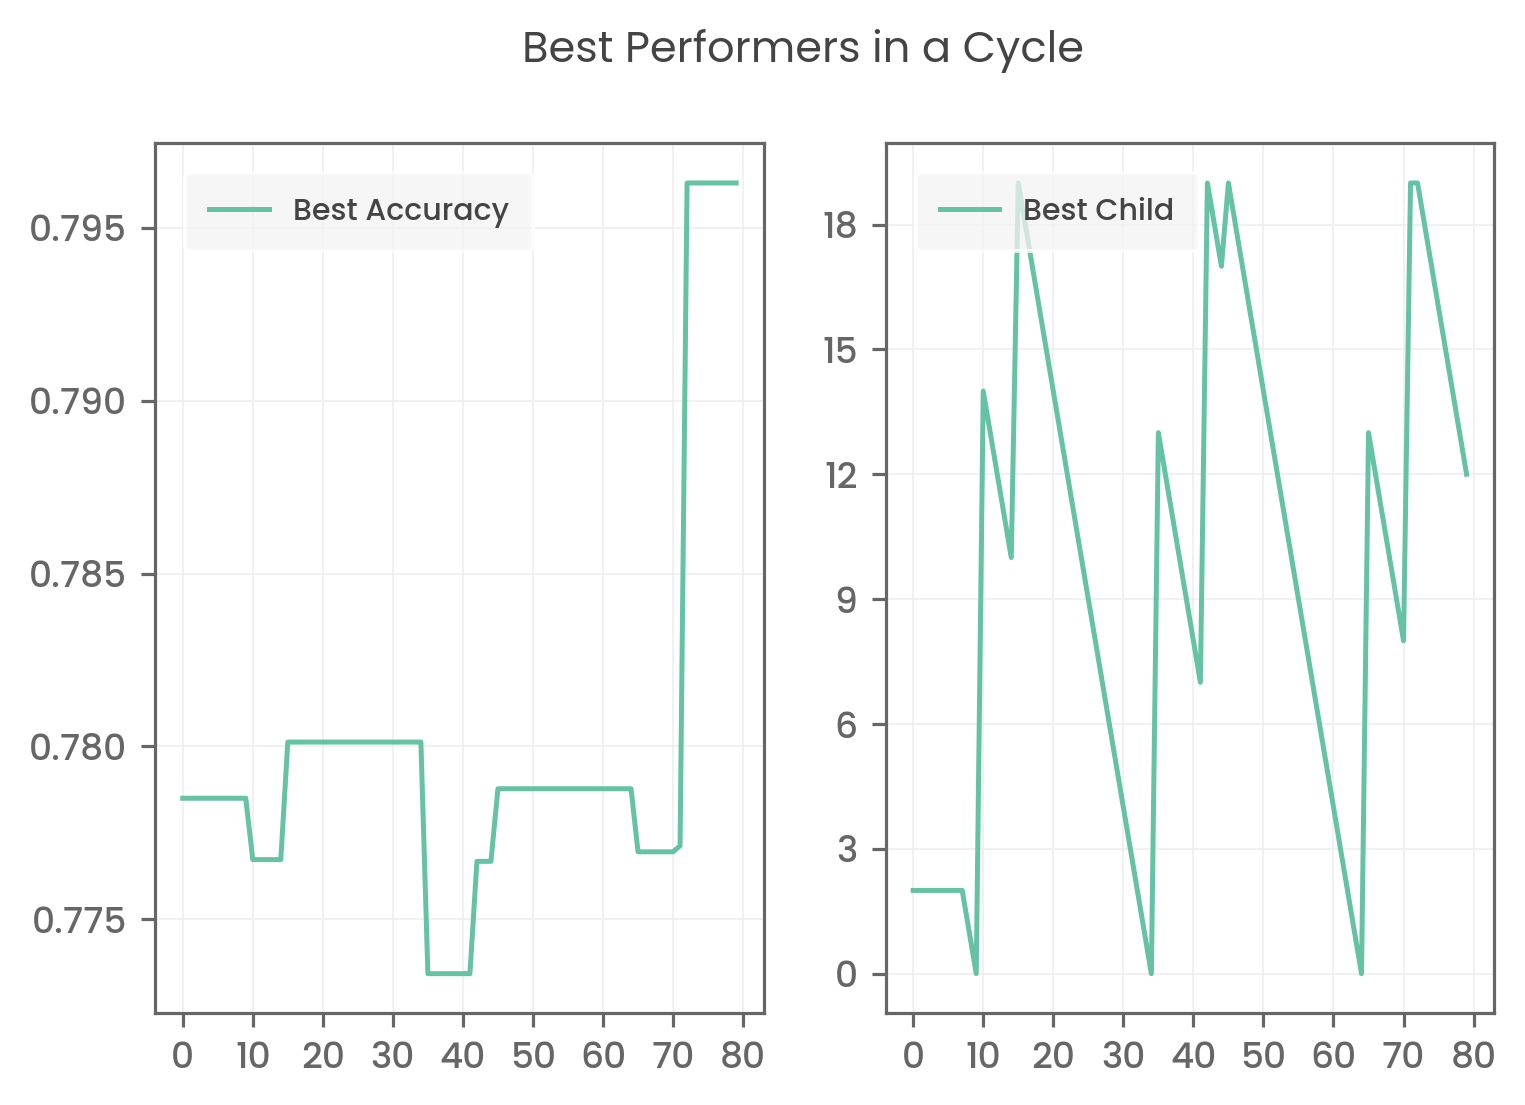

In [13]:
def plot(data, ax, label='', highlight=5, intx=True, inty=False):
    sorted_data = sorted(data)
    sorted_indices = np.argsort(data)

    ax.plot(data, label=label)
    intx and ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    inty and ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.legend()

fig, axes = plt.subplots(1, 2)
fig.suptitle('Best Performers in a Cycle')

ax_acc, ax_child = axes
plot(controller.best_accuracies, ax_acc, label='Best Accuracy')
plot(controller.best_children, ax_child, label='Best Child', inty=True)

print('[{}]'.format(', '.join(f'{q:.4f}' for q in controller.best_accuracies)))
print(controller.best_children)

## Cell Visualization

### Single Layer Visual Cell

In [14]:
class VisualCell(object):
    def __init__(self, state_space, config) -> None:
        self.state_space = state_space
        self.config = config
        self.palette = seaborn.color_palette("mako_r", 7).as_hex()

        self.G = nx.DiGraph()
        self.labels = {
            'input 0': 'input 0',
            'input 1': 'input 1',
            'concat_blocks': 'concat'
        }
        self.colors = {
            'input 0': self.palette[0],
            'input 1': self.palette[1],
            'concat_blocks': self.palette[5]
        }

        # Add input nodes
        for input_state in self.state_space[0]['values']:
            self.G.add_node(
                self.input_label(input_state),
                layer=0
            )

        # Add primary and combination nodes for blocks
        for nid in range(3*CHILD_PARAMS['blocks']):
            self.G.add_node(
                nid,
                layer=self.get_layer_id(nid)
            )

        # Add block combination node
        self.G.add_node('concat_blocks', layer=3)

    def input_label(self, idx) -> str:
        return 'input {}'.format(idx)

    def primary_op_label(self, idx) -> str:
        return self.state_space[1]['values'][idx].replace('_', '\n')

    def combination_op_label(self, idx) -> str:
        return self.state_space[2]['values'][idx]

    def get_node_id(self, bid, item):
        return bid*3 + item

    def get_layer_id(self, nid) -> int:
        return 2 if (nid+1)%3 ==0 else 1

    def compose_block(self, bid, block):
        input_0, input_1, op_1, op_2, comb = block
        nid_op_0, nid_op_1 = self.get_node_id(bid, 0), self.get_node_id(bid, 1)
        nid_comb = self.get_node_id(bid, 2)

        # Add primary styles
        # self.labels[nid_op_0] = self.state_space[1]['values'][op_1]
        self.labels[nid_op_0] = self.primary_op_label(op_1)
        self.labels[nid_op_1] = self.primary_op_label(op_2)

        self.colors[nid_op_0] = self.palette[2]
        self.colors[nid_op_1] = self.palette[3]

        # Add combination styles
        self.labels[nid_comb] = self.state_space[2]['values'][comb]
        self.colors[nid_comb] = self.palette[4]

        # Add incoming edges for primary operations
        self.G.add_edge(
            self.input_label(input_0),
            self.get_node_id(bid, 0),
            color=self.palette[0]
        )
        self.G.add_edge(
            self.input_label(input_1),
            self.get_node_id(bid, 1),
            color=self.palette[1]
        )

        # Add incoming edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 0),
            self.get_node_id(bid, 2),
            color=self.palette[2]
        )
        self.G.add_edge(
            self.get_node_id(bid, 1),
            self.get_node_id(bid, 2),
            color=self.palette[3]
        )

        # Add outgoing edges for the combination operation
        self.G.add_edge(
            self.get_node_id(bid, 2),
            'concat_blocks',
            color=self.palette[4]
        )
    
    def draw(self, ax):
        # Process cell
        for bid in range(self.config.shape[0]):
            self.compose_block(bid, self.config[bid])

        # Create a multipartite layout to arrange inputs, primary
        # and combination operations in their respective layers.
        pos = nx.multipartite_layout(
            self.G,
            subset_key='layer',
            align='horizontal'
        )

        # Configure edge colors
        edge_colors = nx.get_edge_attributes(self.G,'color').values()

        # Draw cell structure
        nx.draw(
            self.G,
            pos=pos,
            node_color=list(map(lambda l: self.colors[l], self.G.nodes)),
            edge_color=edge_colors,
            node_size=list(map(lambda _:500, self.G.nodes)),
            ax=ax,
        )

        # Label cell operations
        nx.draw_networkx_labels(
            self.G,
            pos=pos,
            labels=self.labels,
            font_size=5,
            font_color=self.palette[6],
            ax=ax
        )

# def visualize_cell(ax, config, title='Cell'):
#     ax.set_title(title)

#     visual = VisualCell(STATE_SPACE, config)
#     visual.draw(ax)

# accuracies = list(map(lambda child: child.accuracy, controller.histories))
# num_selected_trials = 3
# visual_size = CHILD_PARAMS['blocks']
# best_configs = list(map(
#     lambda idx: (controller.histories[idx].config, controller.histories[idx].accuracy),
#     np.argsort(accuracies)[-num_selected_trials:][::-1]
# ))

# for idx, (config, accuracy) in enumerate(best_configs):
#     fig, axes = plt.subplots(1, 2, figsize=(2*visual_size, visual_size))
#     visualize_cell(axes[0], config[0], 'Normal Cell')
#     visualize_cell(axes[1], config[1], 'Reduction Cell')
#     fig.suptitle('Accuracy: {:.2f}%'.format(accuracy*100))

# best_configs

### Two Layer Visual Cell

In [15]:
class TwoLayerVisualCell(object):
    def __init__(self, description) -> None:
        """
        We add 1 level each for inputs and outputs
        Each block gets 2 levels, one for primitive operations and
        another for combination operations. Two layer cells have
        blocks in two layers.
        """
        self.description = description
        self.levels = 1 + 2*2 + 1
        self.palette = seaborn.color_palette("mako_r", self.levels+5).as_hex()
        self.layer_0_blocks = self.description.shape[0]//2

        # Node graph
        self.G = nx.DiGraph()
        self.lay_nodes()
    
    def add_nodes(self, nodes, level, labels=[]):
        labels = labels or nodes
        for node, label in zip(nodes, labels):
            self.G.add_node(node, label=label, level=level, color=self.palette[level])
    
    def add_block(self, b_id, block, layer=0):
        # Block operation levels
        primitive_op_level = 1 + 2*layer
        comb_op_level = 1 + 2*layer + 1

        # Node ids
        start_id = block.shape[-1]*b_id
        primitive_0_id, primitive_1_id = start_id, start_id+1
        comb_id = 'block {}'.format(b_id)

        ######## Node Section ########
        self.add_nodes(
            [primitive_0_id, primitive_1_id],
            primitive_op_level,
            labels=list(block[2:4])
        )
        self.add_nodes([comb_id], comb_op_level, labels=[block[4]])

        ######## Edge Section ########
        self.G.add_edge(block[0], primitive_0_id)
        self.G.add_edge(block[1], primitive_1_id)
        self.G.add_edge(primitive_0_id, comb_id)
        self.G.add_edge(primitive_1_id, comb_id)
    
    def lay_nodes(self):
        input_nodes = ['input 0', 'input 1']
        output_nodes = ['output']
        block_outputs = list(map(
            lambda b_id: 'block {}'.format(b_id),
            range(self.description.shape[0])
        ))

        # Lay out input nodes
        self.add_nodes(input_nodes, level=0)

        # First layer blocks
        layer_0_blocks = self.description[:self.layer_0_blocks]

        # Layout the first block layer
        for b_id, block in enumerate(layer_0_blocks):
            self.add_block(b_id, block, layer=0)
        
        # Layout the second block layer
        layer_1_blocks = self.description[self.layer_0_blocks:]
        for b_id, block in enumerate(layer_1_blocks):
            self.add_block(b_id + len(layer_0_blocks), block, layer=1)

        # Lay out output nodes
        self.add_nodes(output_nodes, level=self.levels-1)

        # Connect block outputs to the output node
        for block in block_outputs:
            self.G.add_edge(block, 'output')

    def get_node_attributes(self, name, as_dict=True):
        if as_dict:
            attributes = dict(map(
                lambda item: (item[0], item[1][name]),
                self.G.nodes(data=True)
            ))
        else:
            attributes = list(map(
                lambda item: item[1][name],
                self.G.nodes(data=True)
            ))
        
        return attributes
    
    def draw(self, ax):
        # Create a multipartite layout to arrange inputs, primary
        # and combination operations in their respective layers.
        pos = nx.multipartite_layout(
            self.G,
            subset_key='level',
            align='horizontal'
        )

        # Node Attributes
        labels = self.get_node_attributes(name='label')
        colors = self.get_node_attributes(name='color', as_dict=False)
        node_size=list(map(lambda _:500, self.G.nodes))

        # Draw cell structure
        nx.draw(
            self.G,
            pos=pos,
            node_color=colors,
            # edge_color=edge_colors,
            node_size=node_size,
            ax=ax,
        )

        # Label nodes
        nx.draw_networkx_labels(
            self.G,
            pos=pos,
            labels=labels,
            font_size=5,
            font_color=self.palette[-1],
            ax=ax
        )

# ax = plt.subplot()
# cell_config = controller.population[0].config[0]
# cell_description = search_space.decode(cell_config)
# visual = TwoLayerVisualCell(cell_description)
# visual.draw(ax)

### Visualization

[(array([[[0, 1, 4, 2, 1],
          [1, 1, 4, 1, 0],
          [1, 1, 1, 1, 1],
          [0, 1, 5, 4, 0],
          [0, 1, 2, 1, 0],
          [3, 6, 2, 4, 0],
          [5, 6, 4, 3, 1],
          [5, 6, 2, 2, 0],
          [6, 5, 2, 0, 0],
          [2, 5, 4, 2, 0],
          [6, 6, 3, 0, 1]],
  
         [[1, 1, 1, 0, 1],
          [1, 1, 0, 1, 1],
          [0, 0, 4, 5, 1],
          [0, 0, 0, 5, 0],
          [1, 0, 2, 3, 1],
          [5, 4, 1, 3, 1],
          [3, 2, 5, 4, 1],
          [3, 5, 4, 3, 0],
          [3, 5, 4, 5, 0],
          [6, 5, 1, 3, 1],
          [3, 2, 4, 1, 1]]]),
  0.7962999939918518),
 (array([[[0, 1, 4, 2, 1],
          [1, 1, 4, 1, 0],
          [1, 1, 1, 1, 1],
          [0, 1, 5, 4, 0],
          [0, 1, 2, 5, 0],
          [3, 6, 2, 2, 0],
          [4, 6, 4, 3, 1],
          [5, 6, 2, 2, 0],
          [6, 5, 2, 0, 0],
          [2, 5, 4, 2, 0],
          [4, 6, 3, 0, 1]],
  
         [[1, 1, 1, 0, 1],
          [1, 1, 0, 1, 1],
          [0, 0, 4, 5

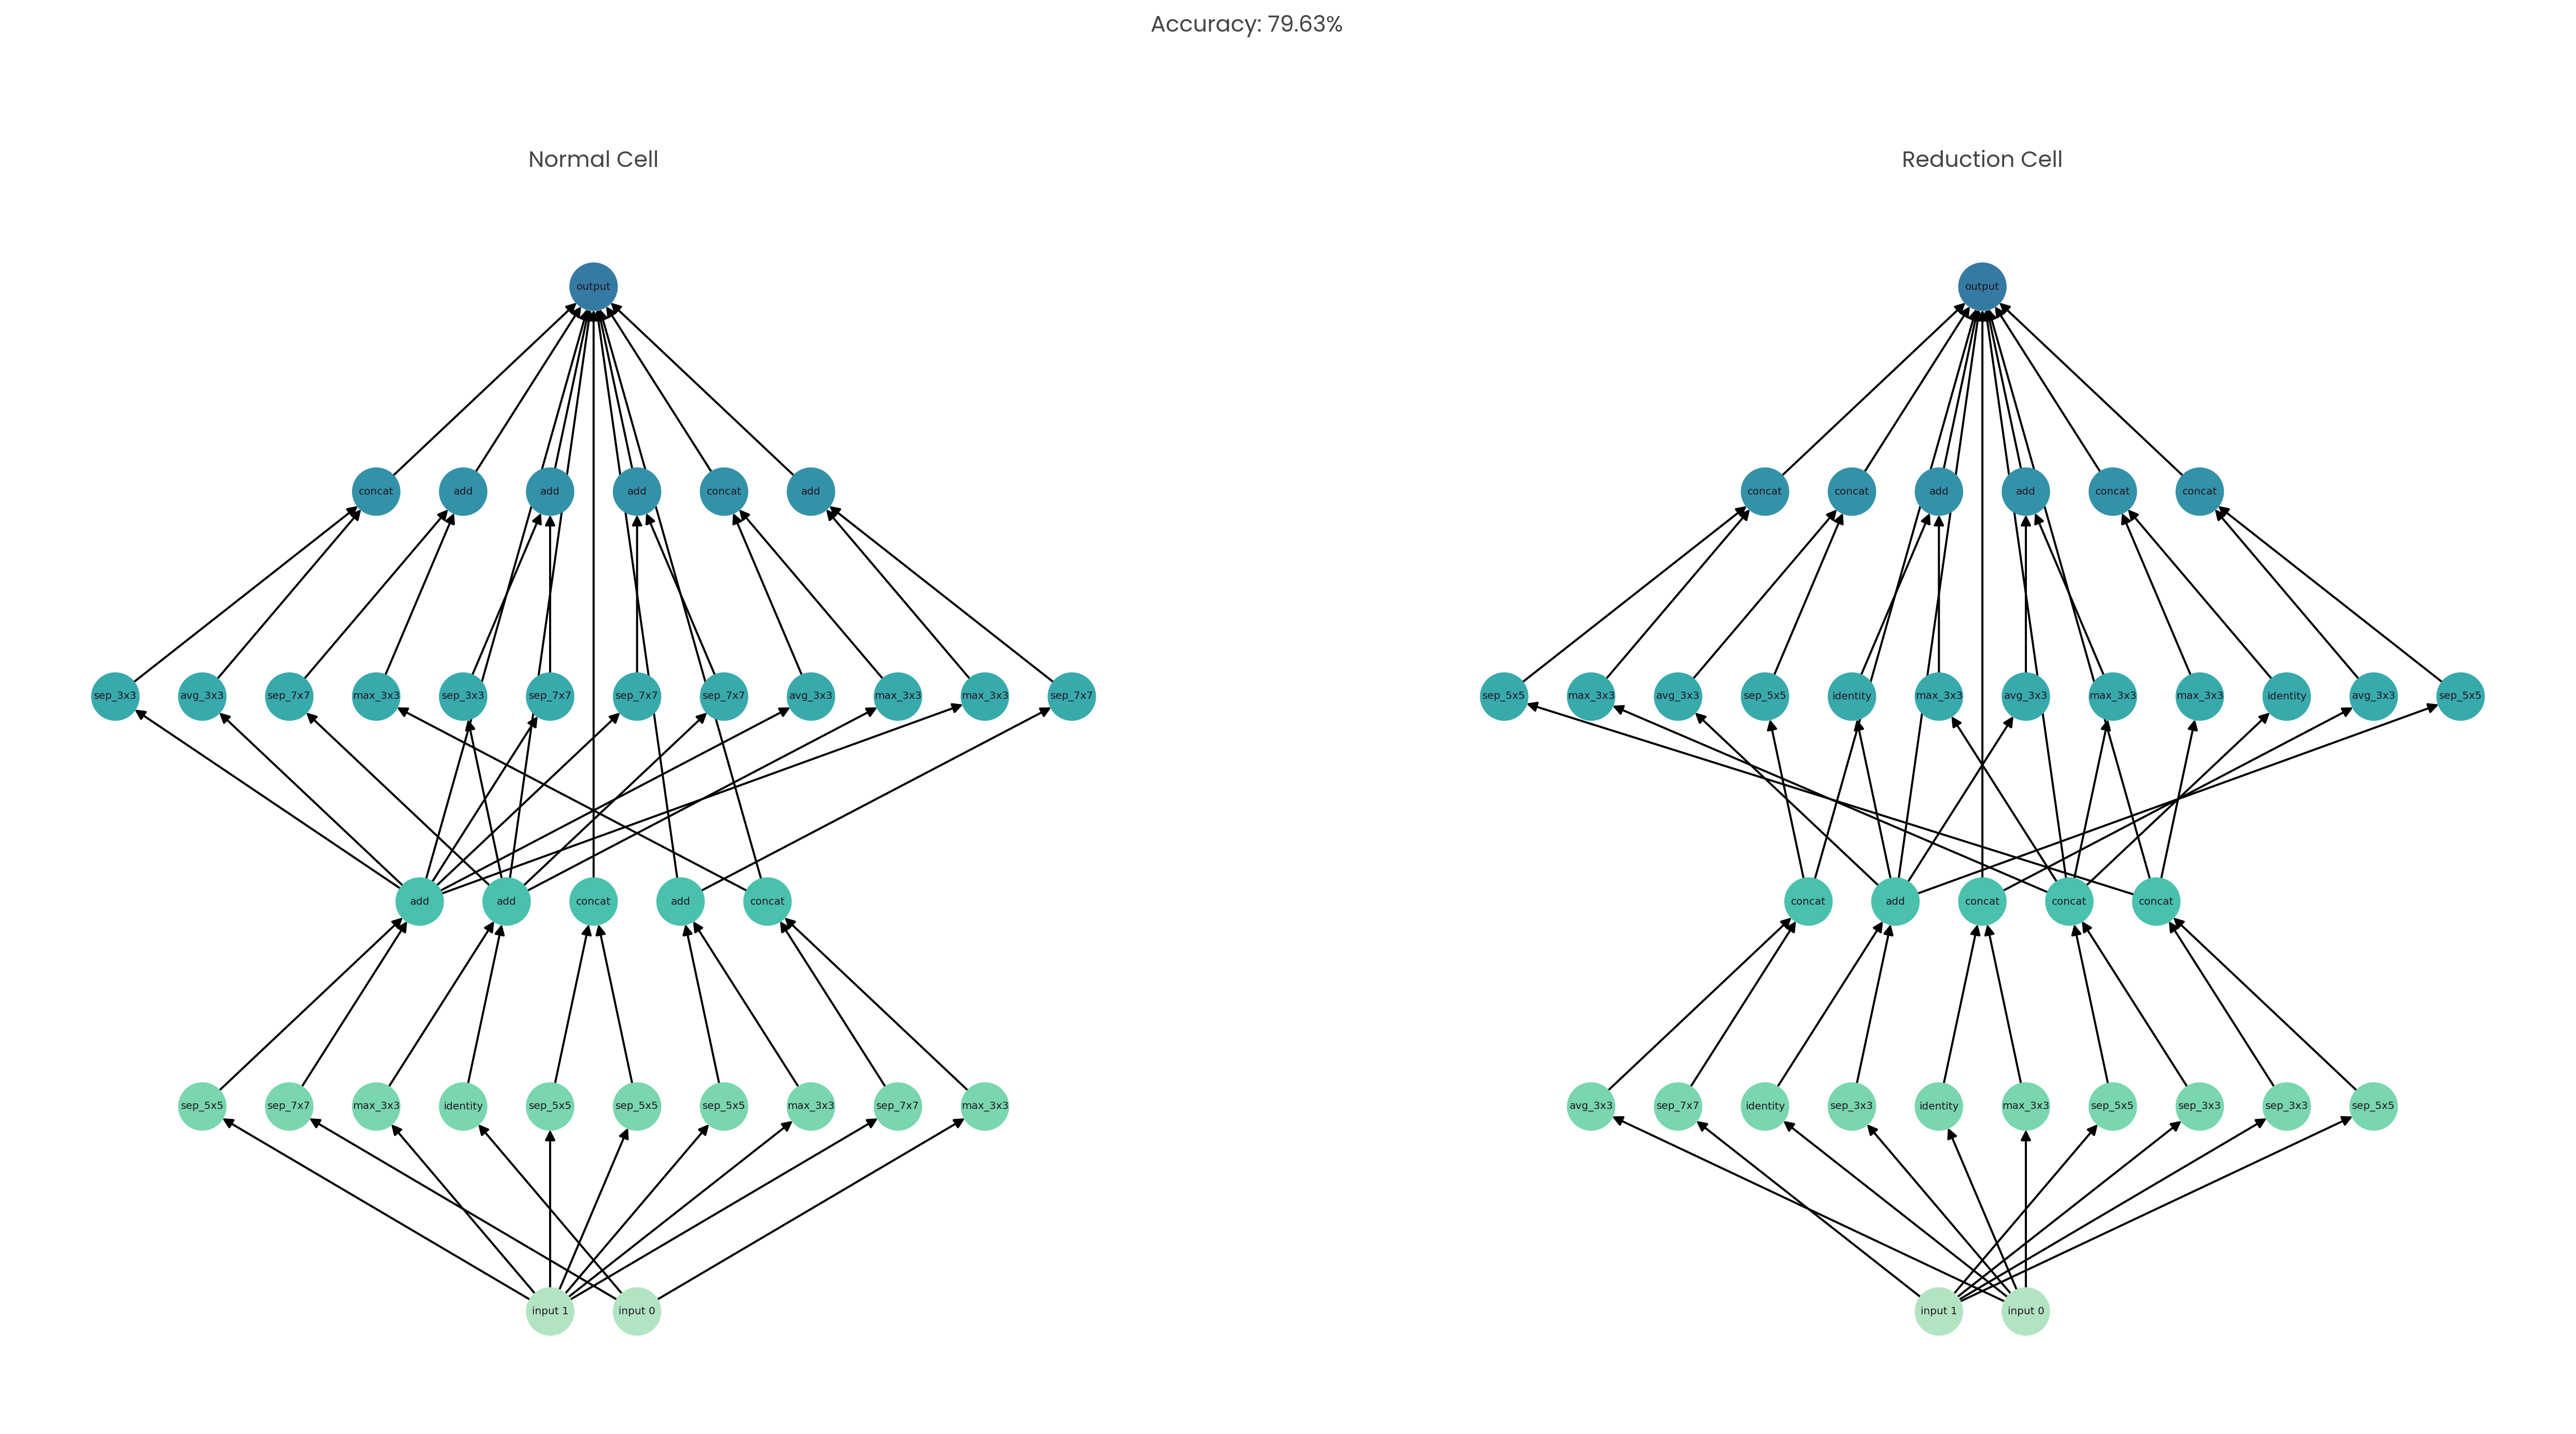

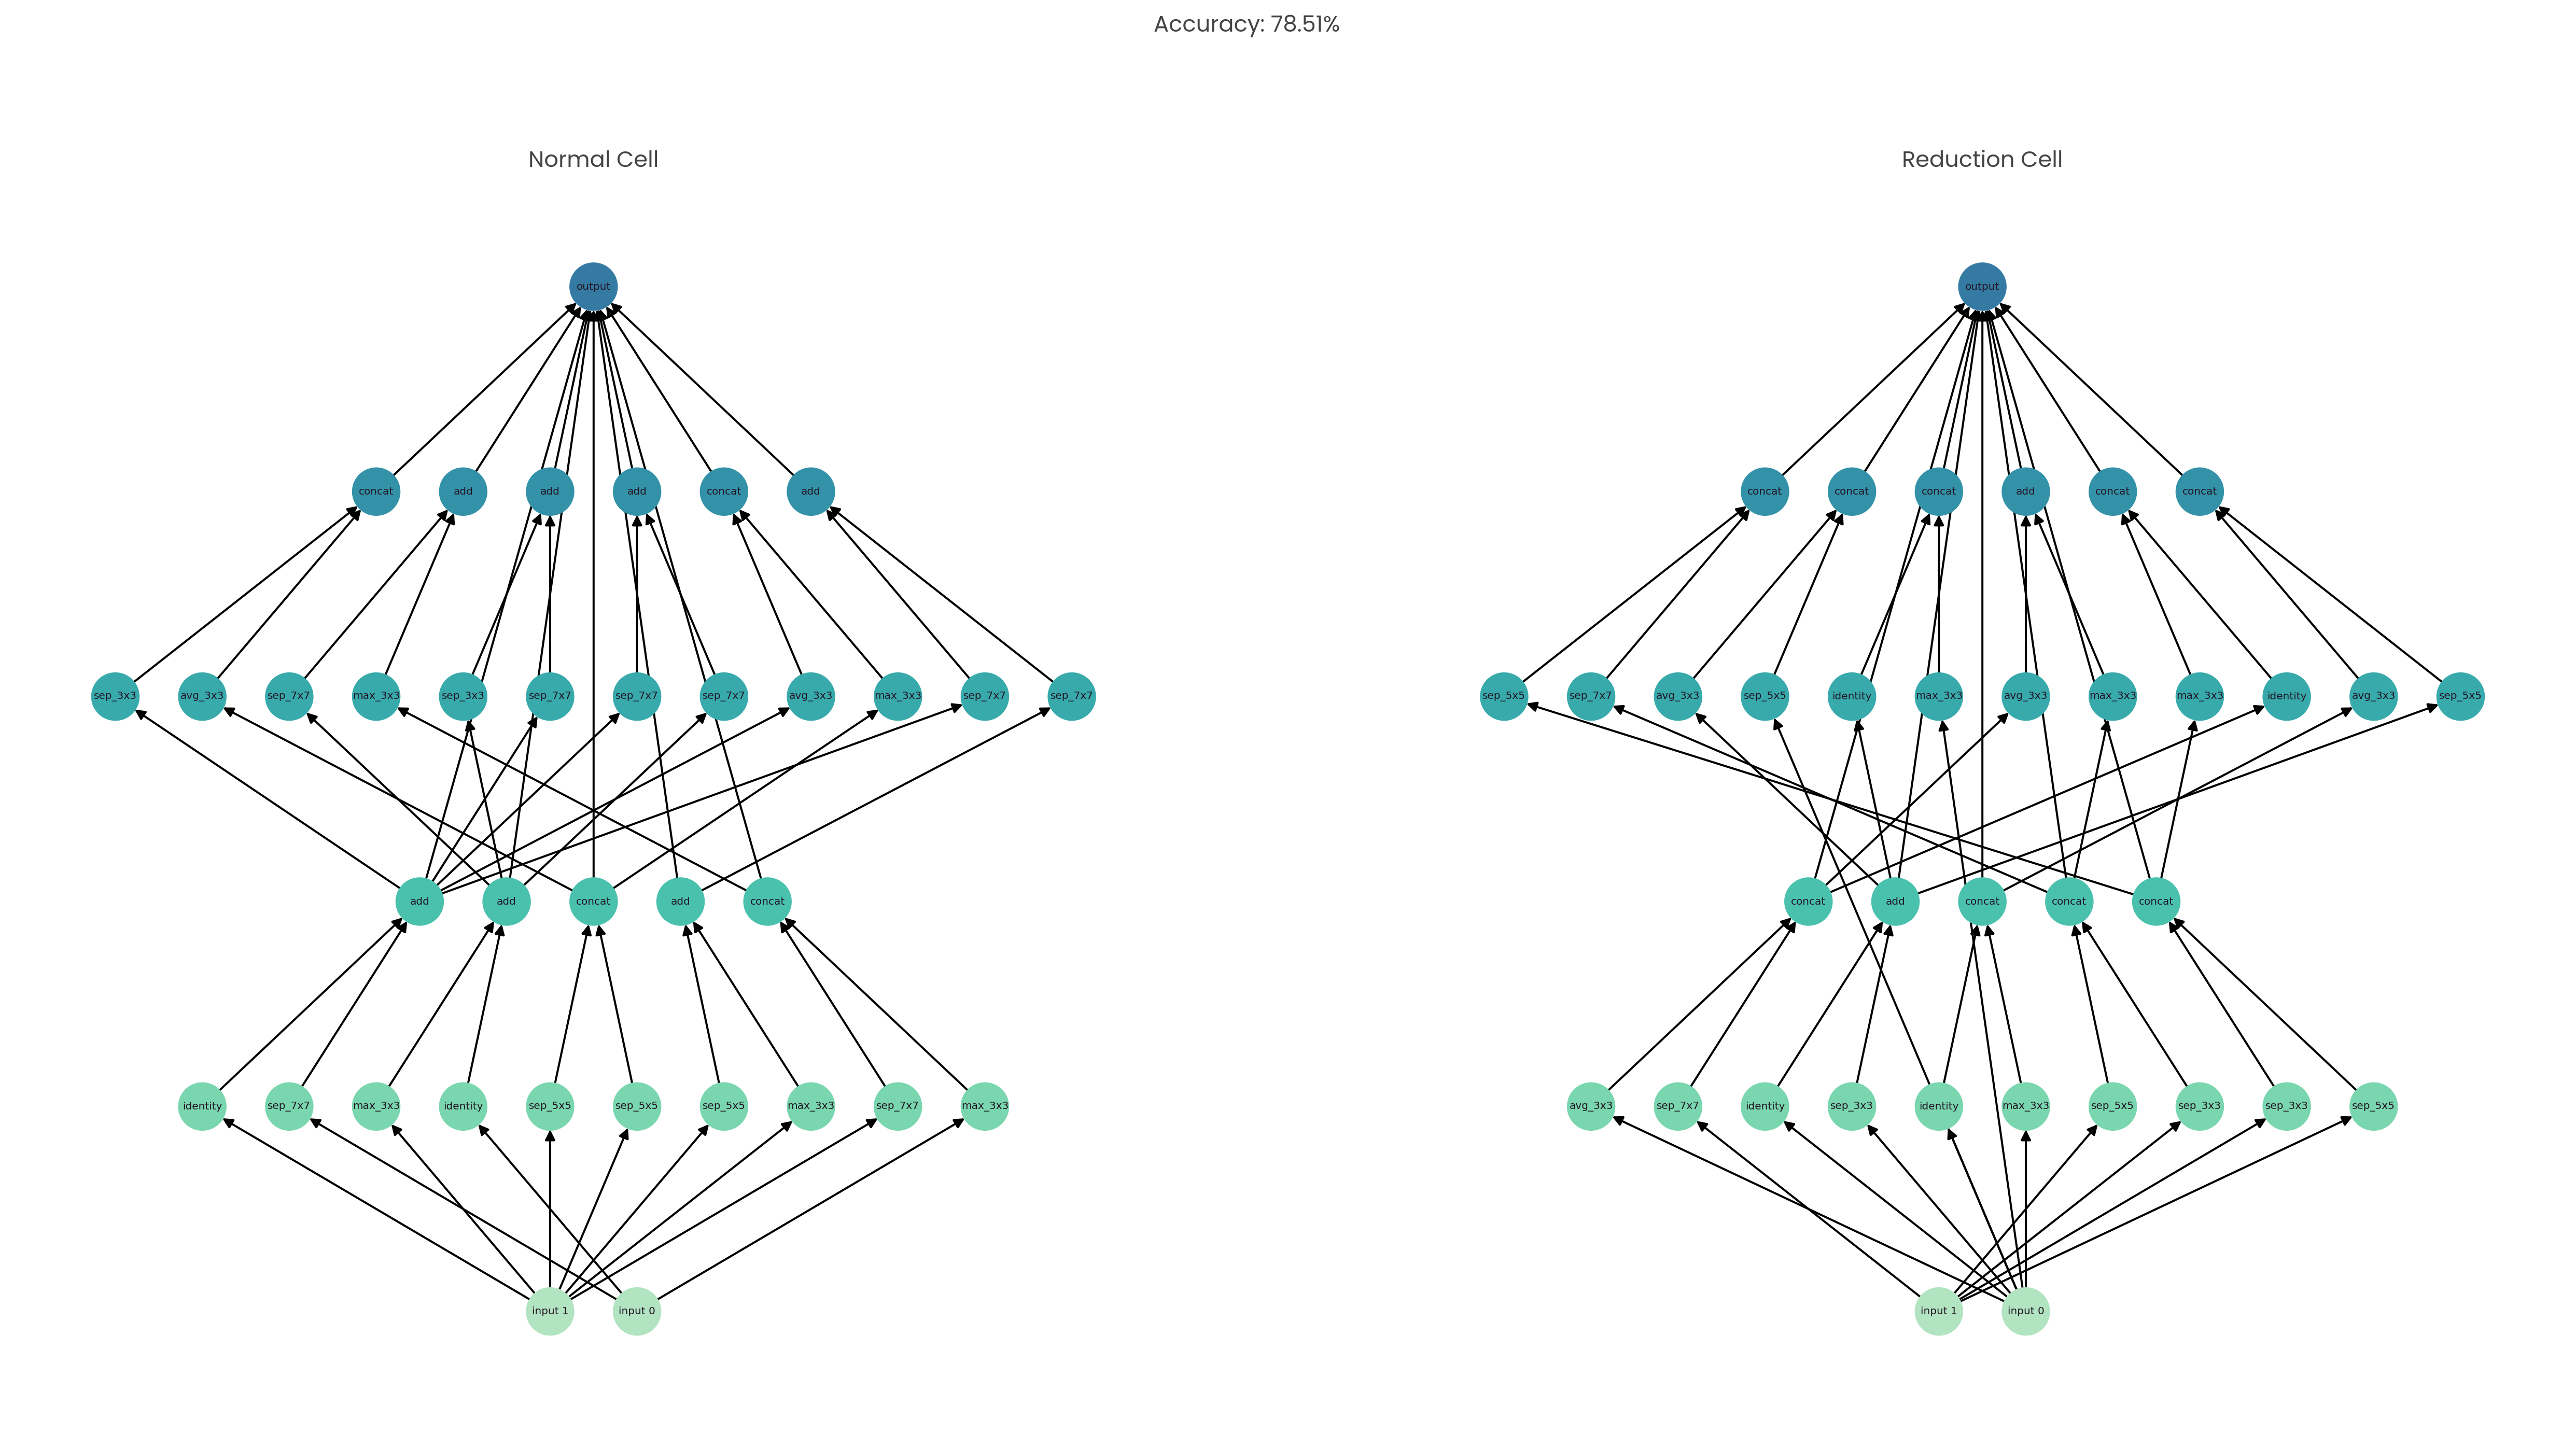

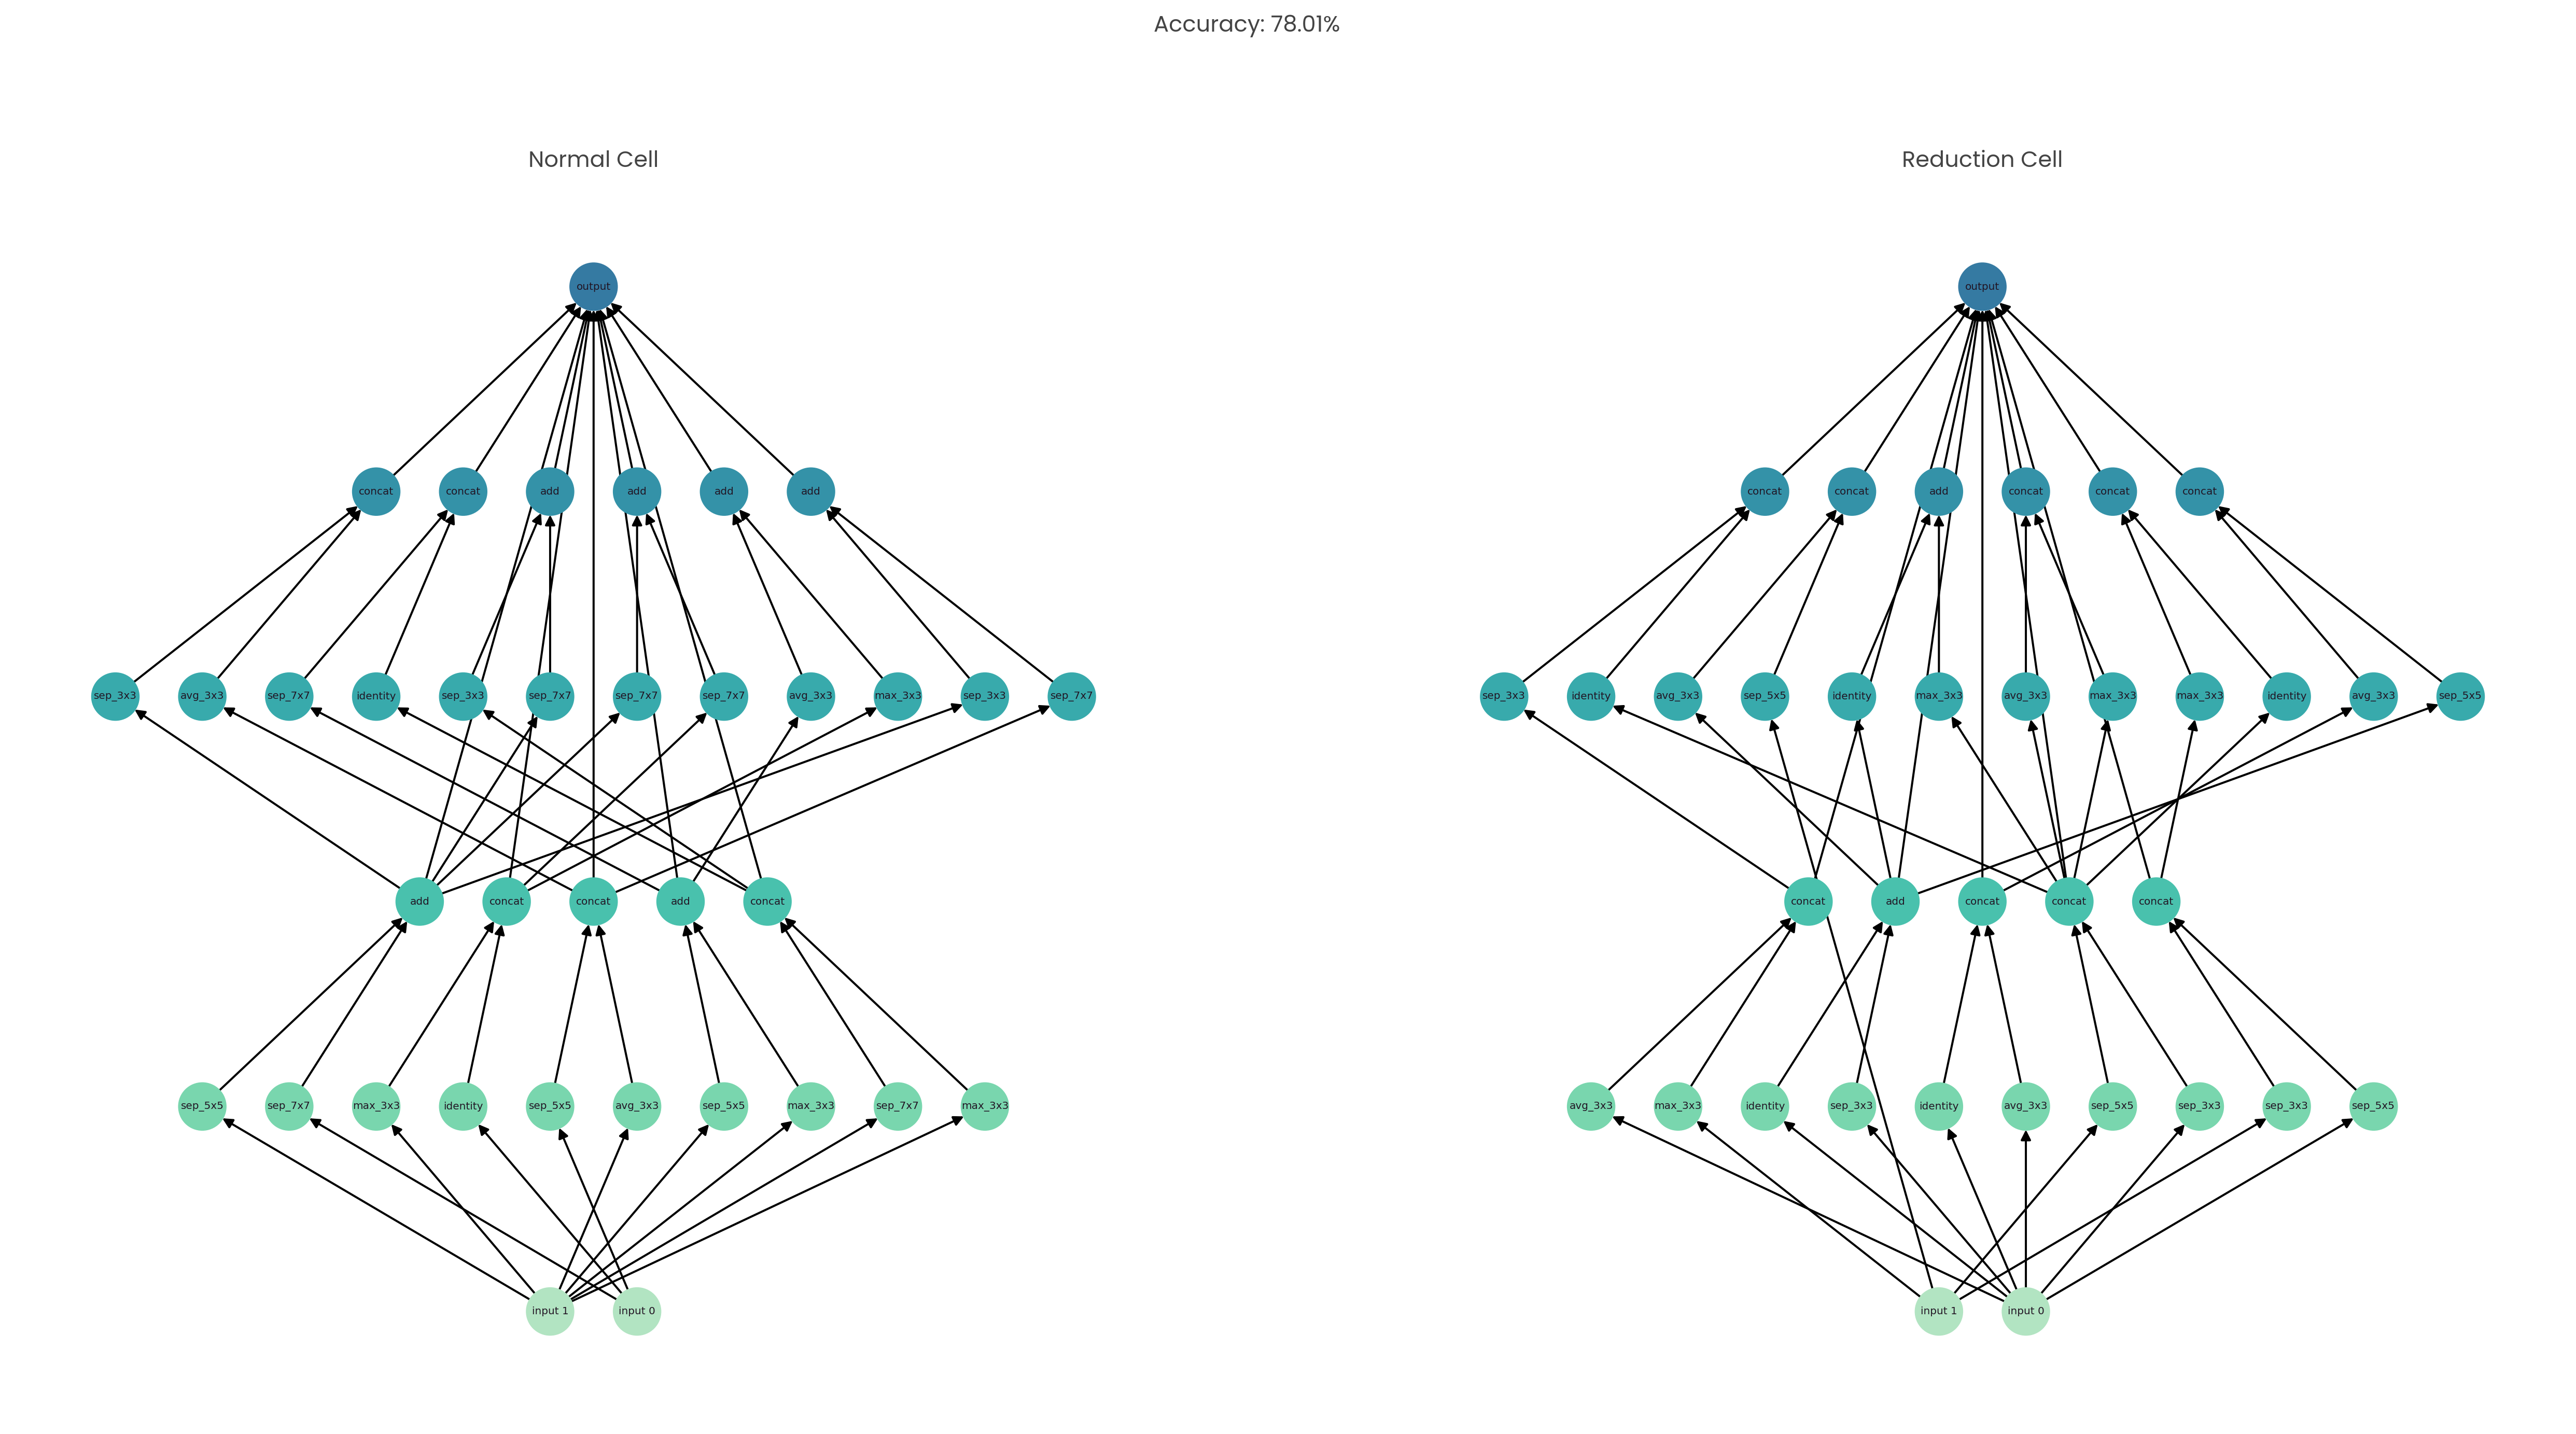

In [16]:
def visualize_cell(ax, config, title='Cell'):
    ax.set_title(title)
    cell_description = search_space.decode(config)

    visual = TwoLayerVisualCell(cell_description)
    visual.draw(ax)

accuracies = list(map(lambda child: child.accuracy, controller.histories))
num_selected_trials = 3
visual_size = CHILD_PARAMS['blocks']
best_configs = list(map(
    lambda idx: (controller.histories[idx].config, controller.histories[idx].accuracy),
    np.argsort(accuracies)[-num_selected_trials:][::-1]
))

for idx, (config, accuracy) in enumerate(best_configs):
    fig, axes = plt.subplots(1, 2, figsize=(2*visual_size, visual_size))
    visualize_cell(axes[0], config[0], 'Normal Cell')
    visualize_cell(axes[1], config[1], 'Reduction Cell')
    fig.suptitle('Accuracy: {:.2f}%'.format(accuracy*100))

best_configs